In [22]:
%load_ext autoreload
#!pip install -r requirements.txt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import torch
%load_ext autoreload
import neptune.new as neptune
from trainers import timegan_generate_data, rtsgan_generator, rgan_generate_data
from utils import *

# Makes sure the same testset is generated every time
np.random.seed(42)
alpha = 0.7
noise = 0
testset = DatasetSinus(num=1000, seq_len=100, alpha=alpha, noise=noise)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]


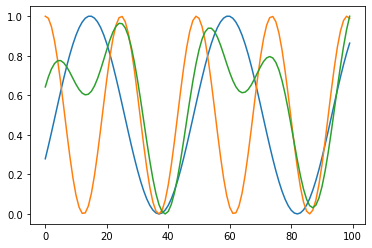

In [24]:
plt.plot(testset[:][0][2]);

In [25]:
%autoreload
# Models
#from architectures.timegan_cnn_DG import *
#from architectures.timegan_cnn_D import *
#from architectures.timegan_cnn_G import *
#from architectures.timegan_cnn_DGER import *
from architectures.timegan import *
#from architectures.RGAN import *
#from architectures.RTSGAN import *

print(f"Loading architecture: {ID}")

Loading architecture: TimeGAN


In [26]:
run_id = "TIMEGAN-218" # RTSGAN-66
#run_id = "RTSGAN-127"

project_name = "timeGAN" if "TIME" in run_id else "RTSGAN"
run = neptune.init_run(
                with_id=run_id, # "TIMEGAN-84"
                project="kohmann/" + project_name,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
                   )
params = run["parameters"].fetch()
#imgs = run["generated_image"].download()
params["device"] = "cpu"
params["testset_size"] = len(testset)
#params["model_name"] = "model_checkpoint.pt"

if "TimeGAN" in ID:
    model = TimeGAN(params)
elif ID == "RGAN":
    model = RGAN(params)
elif ID == "RTSGAN":
    model = RTSGAN(params)
else:
    raise ValueError
model = restore_weights(model, run)


https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-218
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 13 operations to synchronize with Neptune. Do not kill this process.
All 13 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-218


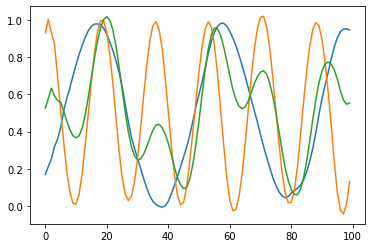

In [27]:
%autoreload
np.random.seed(42)
if "TimeGAN" in ID:
    fake_data = timegan_generate_data(model, torch.tensor(testset.T), params["max_seq_len"], params["Z_dim"])
elif ID == "RGAN":
    fake_data = rgan_generate_data(model, torch.tensor(testset.T), params["max_seq_len"], params["Z_dim"])
elif ID == "RTSGAN":
    fake_data = rtsgan_generator(model, params, eval=True)
else:
    raise ValueError

plt.plot(fake_data[0]);

#### Evaluation methods

https://app.neptune.ai/kohmann/Evaluation/e/EV-27
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
sin1 freq:[1, 3], phase:[-1.5707963267948966, 0]
sin2 freq:[4, 6], phase:[0, 1.5707963267948966]
MSE Error: 0.00561


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Epoch: 299, Train loss: 0.0000, Val loss: 0.0000: 100%|██████████| 300/300 [01:01<00:00,  4.88it/s]

Average Validation MSE: 0.00004769, Average Test MSE: 0.00023634 
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 14 operations to synchronize with Neptune. Do not kill this process.
All 14 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/Evaluation/e/EV-27


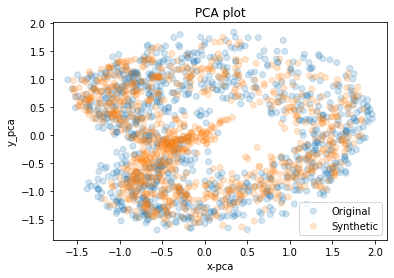

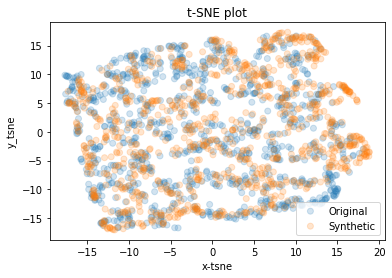

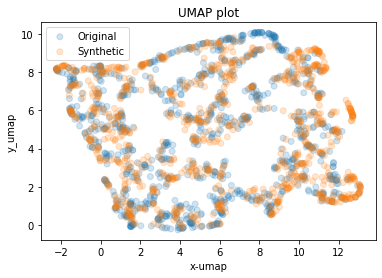

In [28]:
run = neptune.init_run(
    project="kohmann/Evaluation",
    name=ID,
    description="",
    #source_files=["architectures/RTSGAN.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)
run["model_id"] = ID + "-" + run_id.split('-')[-1]

from metrics import compare_sin3_generation, sw_approx, prediction_score # sinkhorn_distance, MMD,
np.random.seed(41)
testset2 = DatasetSinus(num=params["testset_size"], seq_len=100, alpha=alpha, noise=noise)
mse_error = compare_sin3_generation(fake_data, 0.7, 0)
print(f"MSE Error: {mse_error:.5f}")
x = torch.tensor(fake_data)
y = testset[:][0]
y_2 = testset2[:][0]
#wass_dist = sinkhorn_distance(x,y)
#mmd = MMD(x,y)
sw_baseline = sw_approx(y,y_2)
sw = sw_approx(y,x)

run["numeric_results/num_test_samples"] = len(testset)
run["numeric_results/sin3_generation_MSE_loss"] = mse_error

run["numeric_results/SW"] = sw.item()
run["numeric_results/SW_baseline"] = sw_baseline.item()

r = np.array([data[0].numpy() for data in testset])

run["PCA"].upload(visualization(r, fake_data, 'pca'))
run["tSNE"].upload(visualization(r, fake_data, 'tsne'))
run["UMAP"].upload(visualization(r, fake_data, 'umap'))

div = int(len(fake_data)*0.8)
val_loss, test_loss = prediction_score(fake_data[:div], fake_data[div:], testset[:][0], device="cuda", epochs=300, neptune_logger=run)
run["numeric_results/Predtion_score_mean_val"] = np.mean(val_loss).item()
run["numeric_results/Predtion_score_std_val"] = np.std(val_loss).item()

run["numeric_results/Predtion_score_mean_test"] = np.mean(test_loss).item()
run["numeric_results/Predtion_score_std_test"] = np.std(test_loss).item()
run.stop()

In [ ]:
import glob
from PIL import Image

def create_gif(fp_in="neptune/generated_image/*.png", fp_out="neptune/mnist_generation.gif"):
    imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    # extract first image from iterator
    imgs[0].save(fp=fp_out, append_images=imgs,
                 save_all=True, duration=500, loop=0)
    
create_gif()